<a href="https://colab.research.google.com/github/StitchMl/Intrusion-Detection/blob/main/Traccia_T7b_Intrusion_Detection_Matteo_La_Gioia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to the Project

The main objective of this project is to develop a machine learning system capable of analysing network traffic and classifying flows as 'normal' or associated with a specific type of attack.

The **NSL-KDD** dataset (`KDDTrainClean.csv`) is used. Each network flow in the dataset is labelled as normal or belonging to a specific attack category.

#Data Setup

Import the necessary libraries.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

##1. Loading the dataset

In this section, we load the `NSL-KDD` dataset and analyse its structure to understand its main characteristics.


###**Loading the dataset**

We will use the pandas library to read the `KDDTrainClean.csv` file. An error will also be handled if the file is not found.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/KDDTrainClean.csv'
try:
    dataset = pd.read_csv(file_path)
    print("Dataset successfully loaded!")
except FileNotFoundError:
    print(f"Error: the file '{file_path}' was not found. Make sure the path is correct.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset successfully loaded!


###**Initial exploration**

We will check:

In [ ]:
dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


The structure of the dataset (number of rows and columns).

In [ ]:
print("Size of dataset (rows, columns):", dataset.shape)

Size of dataset (rows, columns): (125973, 42)


The data types in each column.

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

The presence of any null values.

In [ ]:
null_counts = dataset.isnull().sum()
print(null_counts[null_counts > 0] if null_counts.any() else "There are no null values in the dataset.")

There are no null values in the dataset.


###**Analysis of class distribution**

The label column represents the label associated with each network flow (e.g. 'normal' or a specific type of attack). We will calculate the class distribution and display the results with a bar graph.

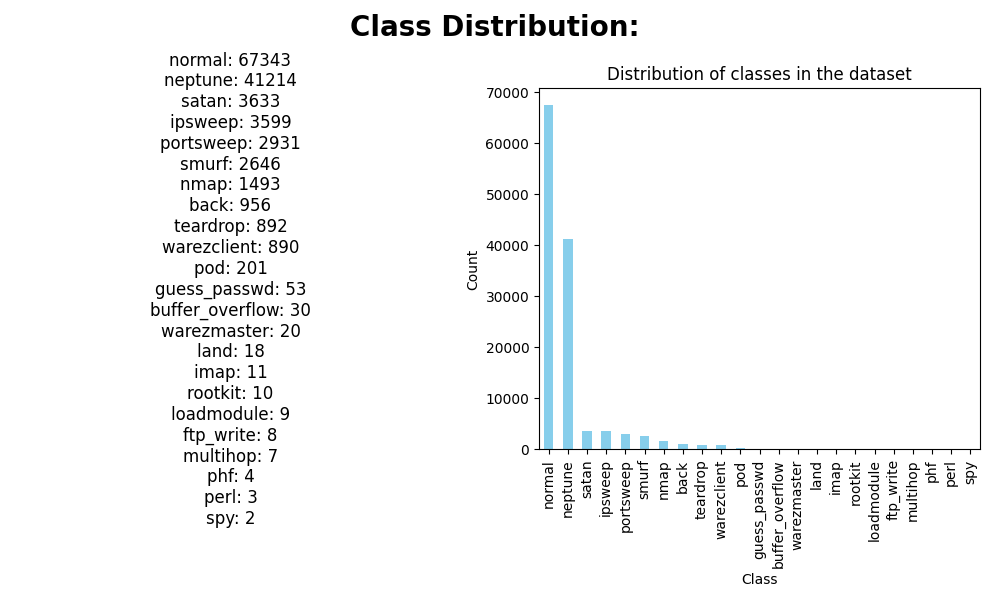

In [ ]:
class_distribution = dataset['label'].value_counts()

# Visualisation of class distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Class Distribution:", fontsize=20, fontweight="bold")
ax[0].axis("off")  # Hides axes for text
text = "\n\n"+"\n".join([f"{key}: {value}" for key, value in class_distribution.items()])
ax[0].text(0.5, 0.5, text, fontsize=12, ha="center", va="center")
class_distribution.plot(kind='bar', color='skyblue')
ax[1].set_title("Distribution of classes in the dataset")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Count")
plt.tight_layout()  # Improve layout
plt.show()

An analysis of the `label` column shows that some classes, such as `spy`, are represented by an extremely small number of examples (only 2) as well as several other classes have fewer than 50 examples, indicating a significant scarcity of data for these categories. This imbalance in the distribution of classes could lead to the least represented classes being neglected in favour of the most common ones. Classes with few examples may not be learnt correctly by the model, leading to poor performance (low precision and recall) on these categories while overall accuracy may appear high, but this metric would not reflect the true ability of the model to correctly classify minor classes. In this case, one can compensate for the imbalance by using approaches such as class weighting (e.g. `class_weight` in Scikit-learn or Keras) or through the use of metrics such as F1-score, precision and recall per class that offer a more accurate view of the model's performance on the lesser represented classes.


##2. Cleaning and preprocessing

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

###**Management of null values**

After an initial analysis of the dataset, it was verified that no null values were present. Therefore, there is no need to apply data imputation or removal techniques.

###**Normalisation of numerical features**

All numerical features in the dataset are normalised using the Standard Scaler, so that they have a mean of zero and a unit standard deviation.

In [ ]:
# Identifying numeric columns
numeric_columns = dataset.select_dtypes(include=np.number).columns
print("Number columns identified:"+"\n-\t".join([f"{name}" for name in list(numeric_columns)]))

Number columns identified:duration
-	src_bytes
-	dst_bytes
-	land
-	wrong_fragment
-	urgent
-	hot
-	num_failed_logins
-	logged_in
-	num_compromised
-	root_shell
-	su_attempted
-	num_root
-	num_file_creations
-	num_shells
-	num_access_files
-	num_outbound_cmds
-	is_host_login
-	is_guest_login
-	count
-	srv_count
-	serror_rate
-	srv_serror_rate
-	rerror_rate
-	srv_rerror_rate
-	same_srv_rate
-	diff_srv_rate
-	srv_diff_host_rate
-	dst_host_count
-	dst_host_srv_count
-	dst_host_same_srv_rate
-	dst_host_diff_srv_rate
-	dst_host_same_src_port_rate
-	dst_host_srv_diff_host_rate
-	dst_host_serror_rate
-	dst_host_srv_serror_rate
-	dst_host_rerror_rate
-	dst_host_srv_rerror_rate


In [ ]:
# Applying the scaler standard
scaler = StandardScaler()
dataset[numeric_columns] = scaler.fit_transform(dataset[numeric_columns])

###**Label Encoding**

The label column is converted into numerical values using the Label Encoding algorithm.

In [ ]:
label_encoder = LabelEncoder()
dataset['label'] = label_encoder.fit_transform(dataset['label'])
print("The labels were converted into numerical values.")
print("Mapping the original classes:")
for index, class_label in enumerate(label_encoder.classes_):
    print(f"  {index}:\t{class_label}")

The labels were converted into numerical values.
Mapping the original classes:
  0:	back
  1:	buffer_overflow
  2:	ftp_write
  3:	guess_passwd
  4:	imap
  5:	ipsweep
  6:	land
  7:	loadmodule
  8:	multihop
  9:	neptune
  10:	nmap
  11:	normal
  12:	perl
  13:	phf
  14:	pod
  15:	portsweep
  16:	rootkit
  17:	satan
  18:	smurf
  19:	spy
  20:	teardrop
  21:	warezclient
  22:	warezmaster


Do the same for non-numerical features (`protocol_type`, `service`, `flag`)

In [ ]:
protocol_encoder = LabelEncoder()
dataset['protocol_type'] = protocol_encoder.fit_transform(dataset['protocol_type'])
print("The features were converted into numerical values.")
print("Mapping the original classes of protocol_type:")
for index, class_label in enumerate(protocol_encoder.classes_):
    print(f"  {index}:\t{class_label}")

The features were converted into numerical values.
Mapping the original classes of protocol_type:
  0:	icmp
  1:	tcp
  2:	udp


In [ ]:
service_encoder = LabelEncoder()
dataset['service'] = service_encoder.fit_transform(dataset['service'])
print("The features were converted into numerical values.")
print("Mapping the original classes of service:")
for index, class_label in enumerate(service_encoder.classes_):
    print(f"  {index}:\t{class_label}")

The features were converted into numerical values.
Mapping the original classes of service:
  0:	IRC
  1:	X11
  2:	Z39_50
  3:	aol
  4:	auth
  5:	bgp
  6:	courier
  7:	csnet_ns
  8:	ctf
  9:	daytime
  10:	discard
  11:	domain
  12:	domain_u
  13:	echo
  14:	eco_i
  15:	ecr_i
  16:	efs
  17:	exec
  18:	finger
  19:	ftp
  20:	ftp_data
  21:	gopher
  22:	harvest
  23:	hostnames
  24:	http
  25:	http_2784
  26:	http_443
  27:	http_8001
  28:	imap4
  29:	iso_tsap
  30:	klogin
  31:	kshell
  32:	ldap
  33:	link
  34:	login
  35:	mtp
  36:	name
  37:	netbios_dgm
  38:	netbios_ns
  39:	netbios_ssn
  40:	netstat
  41:	nnsp
  42:	nntp
  43:	ntp_u
  44:	other
  45:	pm_dump
  46:	pop_2
  47:	pop_3
  48:	printer
  49:	private
  50:	red_i
  51:	remote_job
  52:	rje
  53:	shell
  54:	smtp
  55:	sql_net
  56:	ssh
  57:	sunrpc
  58:	supdup
  59:	systat
  60:	telnet
  61:	tftp_u
  62:	tim_i
  63:	time
  64:	urh_i
  65:	urp_i
  66:	uucp
  67:	uucp_path
  68:	vmnet
  69:	whois


In [ ]:
flag_encoder = LabelEncoder()
dataset['flag'] = flag_encoder.fit_transform(dataset['flag'])
print("The features were converted into numerical values.")
print("Mapping the original classes of flag:")
for index, class_label in enumerate(flag_encoder.classes_):
    print(f"  {index}:\t{class_label}")

The features were converted into numerical values.
Mapping the original classes of flag:
  0:	OTH
  1:	REJ
  2:	RSTO
  3:	RSTOS0
  4:	RSTR
  5:	S0
  6:	S1
  7:	S2
  8:	S3
  9:	SF
  10:	SH


After these steps, the data set is ready for model training. The changes made ensure that the data are in a consistent and optimal format for analysis.

In [ ]:
dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,-0.110249,1,20,9,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,11
1,-0.110249,2,44,9,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,11
2,-0.110249,1,49,5,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,9
3,-0.110249,1,24,9,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,11
4,-0.110249,1,24,9,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,11


##3. Exploratory analysis

In this section, we focus on two main aspects:
* Correlation between numerical characteristics
* Distribution of classes.

In [ ]:
import seaborn as sns

###**Correlation Analysis**

The correlation matrix is calculated, representing the degree of linear relationship between each pair of numerical characteristics.

In [ ]:
correlation_matrix = dataset.corr()

Visualise the matrix with a heatmap using the `seaborn` library. Darker cells indicate a strong, positive or negative correlation.

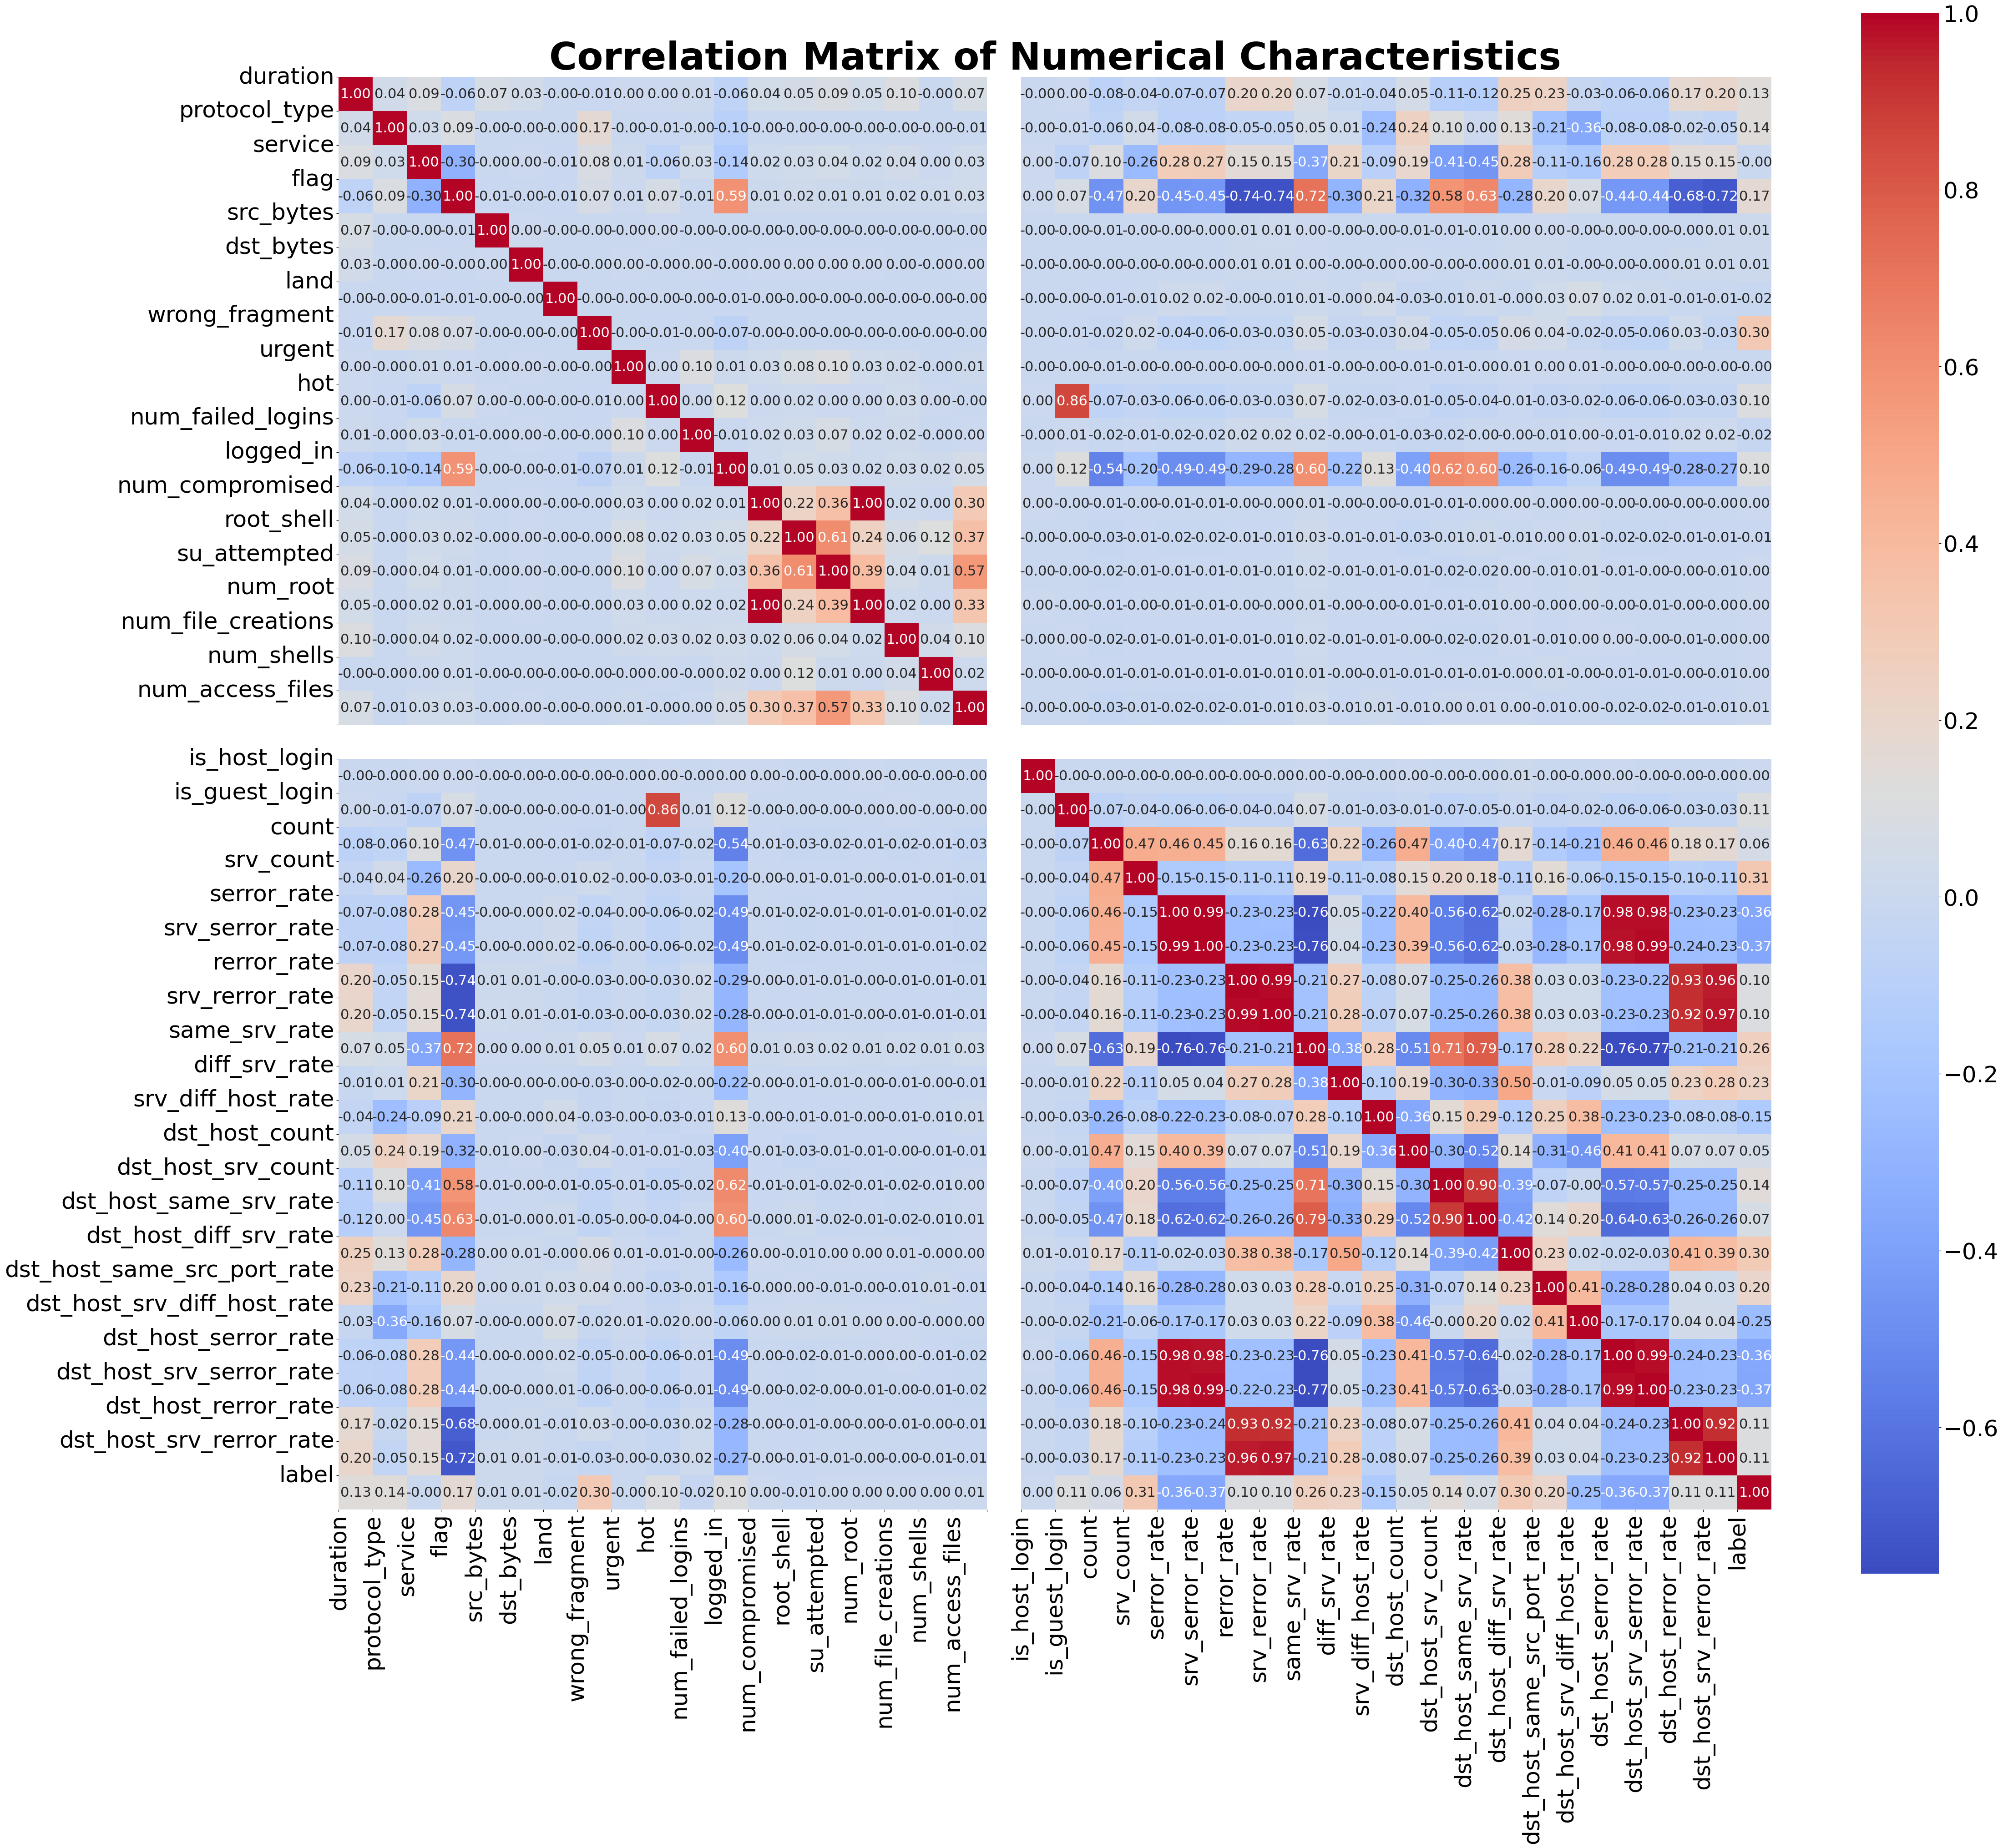

In [ ]:
# Calculates the dynamic dimensions of the figure based on the number of variables
num_variables = correlation_matrix.shape[0]
cell_size = 1  # Basic size of each cell in inches
fig_width = cell_size * num_variables + 5  # Dynamic width
fig_height = cell_size * num_variables + 5  # Dynamic height

# Create heatmap with proportionate size
plt.figure(figsize=(fig_width, fig_height))
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,  # Show values in cells
    cmap="coolwarm",  # Colormap
    fmt=".2f",  # Format of values
    cbar=True,  # Colour bar
    square=True,  # Create square cells for a uniform layout
    annot_kws={"size": 22},  # Increases the font of values in cells
    cbar_kws={"shrink": 0.8, "aspect": 20,}  # Reduces the size of the colour bar
)

# Customise colourbar font
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=36)  # Font of colourbar values

# Remove only the label 'num_outbound_cmds' from the axes
labels = correlation_matrix.columns.tolist()  # Get all labels
filtered_labels = [label if label != "num_outbound_cmds" else "" for label in labels]  # Replace with empty string

# Set up customised labels
plt.xticks(ticks=range(len(filtered_labels)), labels=filtered_labels, rotation=90, fontsize=36)
plt.yticks(ticks=range(len(filtered_labels)), labels=filtered_labels, rotation=0, fontsize=36)

plt.title("Correlation Matrix of Numerical Characteristics", fontsize=60, fontweight="bold")
plt.tight_layout()
plt.show()

We identify feature pairs with absolute correlation above a predefined threshold. These highly correlated features can be considered redundant and potentially removed to improve the efficiency and performance of the model.

In [ ]:
threshold = 0.8  # Threshold for high correlations
high_corr_pairs = correlation_matrix[
    (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1)]
print("Highly correlated pairs of characteristics (threshold > 0.8):")
processed_columns = set()  # Set to keep track of already processed columns
columns_to_remove = set()  # Set to store columns to be removed
for col in high_corr_pairs.columns:
    if col not in processed_columns:
        # Find all related features for this column
        correlated_features = high_corr_pairs.index[high_corr_pairs[col].notna()].tolist()
        # Filter already processed features
        correlated_features = [feature for feature in correlated_features
                               if feature not in processed_columns]
        if correlated_features:
            print(f" - {col}: {correlated_features}")
            # Add related columns to the removal list (except the main column)
            columns_to_remove.update(correlated_features)
        # Add the column and its correlates to the set of processed columns
        processed_columns.update(correlated_features + [col])

Highly correlated pairs of characteristics (threshold > 0.8):
 - hot: ['is_guest_login']
 - num_compromised: ['num_root']
 - serror_rate: ['srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']
 - rerror_rate: ['srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
 - dst_host_srv_count: ['dst_host_same_srv_rate']


Highly correlated columns are removed to improve the performance and efficiency of the model.

In [ ]:
print("Removing highly correlated columns:")
columns_to_remove = list(columns_to_remove)
print(columns_to_remove)

dataset = dataset.drop(columns=columns_to_remove, axis=1)
print("Size of dataset (rows, columns):", dataset.shape)

# Output del dataset ridotto
print("Dataset after removing highly correlated features:")
dataset.head()

Removing highly correlated columns:
['dst_host_srv_rerror_rate', 'dst_host_same_srv_rate', 'srv_serror_rate', 'num_root', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'is_guest_login']
Size of dataset (rows, columns): (125973, 33)
Dataset after removing highly correlated features:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,label
0,-0.110249,1,20,9,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.374362,0.771283,-0.349683,-0.374560,-0.324063,-0.818890,-0.280282,0.069972,-0.289103,11
1,-0.110249,2,44,9,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.374362,-1.321428,0.482201,-0.374560,0.734343,-1.035688,2.736852,2.367737,-0.289103,11
2,-0.110249,1,49,5,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.374362,-1.389669,0.038529,-0.374560,0.734343,-0.809857,-0.174417,-0.480197,-0.289103,9
3,-0.110249,1,24,9,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.374362,0.771283,-0.349683,-0.374560,-1.533670,1.258754,-0.439078,-0.383108,0.066252,11
4,-0.110249,1,24,9,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.374362,0.771283,-0.349683,-0.028179,0.734343,1.258754,-0.439078,-0.480197,-0.289103,11


###Distribution of classes

We analyse and visualise the distribution of the classes in the dataset in order to understand any imbalances in the labels and decide whether to implement further transformations of the dataset and/or the choice of suitable evaluation metrics.

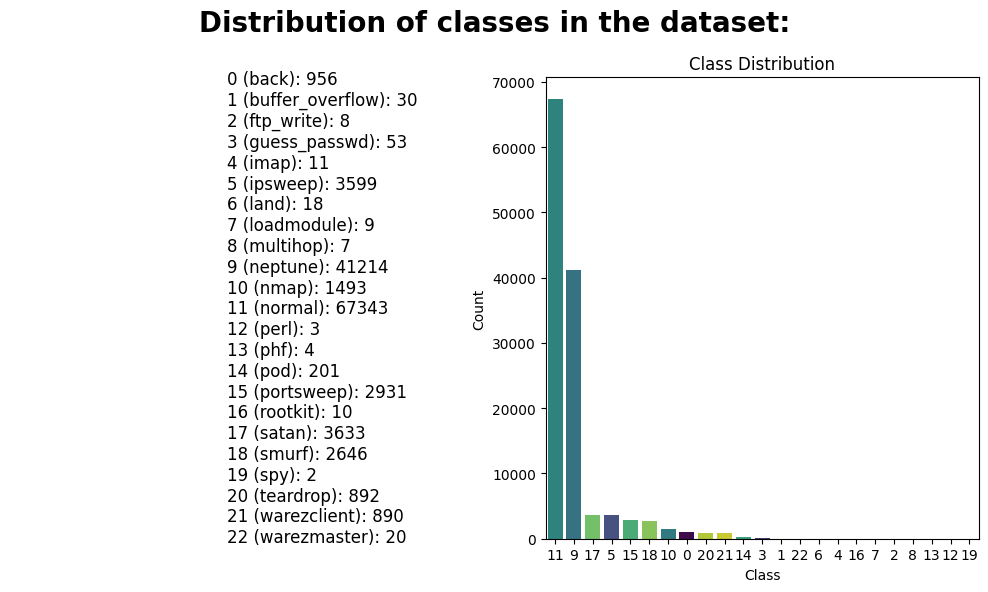

In [ ]:
class_distribution = dataset['label'].value_counts()
class_distribution = class_distribution.sort_values(ascending=False)

# Distribution bar graph
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Distribution of classes in the dataset:", fontsize=20, fontweight="bold")
ax[0].axis("off")  # Hides axes for text
text = ""+"\n".join([f"{index} ({class_label}): {class_distribution[index]}" for index, class_label in enumerate(label_encoder.classes_)])
ax[0].text(0.5, 0.5, text, fontsize=12, ha="left", va="center")
sns.barplot(x=class_distribution.index, y=class_distribution.values,
            palette="viridis", order=class_distribution.index,  # Specific order for the graph
            hue=class_distribution.index, legend=False)
ax[1].set_title("Class Distribution")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

Given the large overestimation of values for the `neptune` class and the `normal` class, it was decided to reduce the number of parameters to the average value of the various class counts with a maximum of 3600 values.

In [ ]:
# Limit the maximum number of items per class
max_elements_per_class = dataset['label'].value_counts()
max_elements_per_class[max_elements_per_class>3600] = 3600
max_elements_per_class = max_elements_per_class.mean().astype(int)
print(f"The maximum number of items per class is {max_elements_per_class}")

The maximum number of items per class is 1068


In [ ]:
# Reduce the number of elements for each class
dataset = dataset.groupby('label')[dataset.columns.tolist()].apply(
    lambda group: group.sample(n=min(len(group), max_elements_per_class),
                               random_state=42), include_groups=False
)

# Calculate post-reduction class distribution
class_distribution_limited = dataset['label'].value_counts()

# Output of the new distribution
print("Size of dataset (rows, columns):", dataset.shape)
print(f"Class distribution after limiting to 3600 elements per class:"+"\n".join([f"{index} ({class_label}): {class_distribution[index]}" for index, class_label in enumerate(label_encoder.classes_)]))

# View reduced dataset
print("First rows of the reduced dataset:")
dataset.head()

Size of dataset (rows, columns): (10590, 33)
Class distribution after limiting to 3600 elements per class:0 (back): 956
1 (buffer_overflow): 30
2 (ftp_write): 8
3 (guess_passwd): 53
4 (imap): 11
5 (ipsweep): 3599
6 (land): 18
7 (loadmodule): 9
8 (multihop): 7
9 (neptune): 41214
10 (nmap): 1493
11 (normal): 67343
12 (perl): 3
13 (phf): 4
14 (pod): 201
15 (portsweep): 2931
16 (rootkit): 10
17 (satan): 3633
18 (smurf): 2646
19 (spy): 2
20 (teardrop): 892
21 (warezclient): 890
22 (warezmaster): 20
First rows of the reduced dataset:


duration  protocol_type  service  flag  src_bytes  dst_bytes  \
label                                                                        
0     43381  -0.110249              1       24     9   0.001529  -0.002851   
      113528 -0.110249              1       24     9   0.001529  -0.002851   
      66446  -0.110249              1       24     9   0.001529  -0.002851   
      70093  -0.110249              1       24     9   0.001529  -0.002851   
      89772  -0.110249              1       24     9   0.001529  -0.002851   

                  land  wrong_fragment    urgent       hot  ...  rerror_rate  \
label                                                       ...                
0     43381  -0.014089       -0.089486 -0.007736  0.835174  ...    -0.374362   
      113528 -0.014089       -0.089486 -0.007736  0.835174  ...    -0.374362   
      66446  -0.014089       -0.089486 -0.007736  0.835174  ...    -0.374362   
      70093  -0.014089       -0.089486 -0.007736  0.835174  ...    -0.374362   
      89772  -0.014089       -0.089486 -0.007736  0.835174  ...    -0.374362   

              same_srv_rate  diff_srv_rate  srv_diff_host_rate  \
label                                                            
0     43381        0.771283      -0.349683           -0.374560   
      113528       0.771283      -0.349683           -0.374560   
      66446        0.771283      -0.349683            1.549779   
      70093        0.771283      -0.349683           -0.374560   
      89772        0.771283      -0.349683           -0.374560   

              dst_host_count  dst_host_srv_count  dst_host_diff_srv_rate  \
label                                                                      
0     43381        -0.334143            0.301231               -0.439078   
      113528       -1.392549           -0.647258               -0.439078   
      66446         0.734343            1.258754               -0.439078   
      70093        -1.009507           -0.303996               -0.439078   
      89772        -0.898626           -0.204630               -0.439078   

              dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  label  
label                                                                          
0     43381                     -0.447834                    -0.289103      0  
      113528                    -0.415471                    -0.289103      0  
      66446                     -0.480197                    -0.289103      0  
      70093                     -0.447834                    -0.289103      0  
      89772                     -0.447834                    -0.289103      0  

[5 rows x 33 columns]

After reducing the maximum number of elements for classes, we display the new distribution of labels in the dataset.

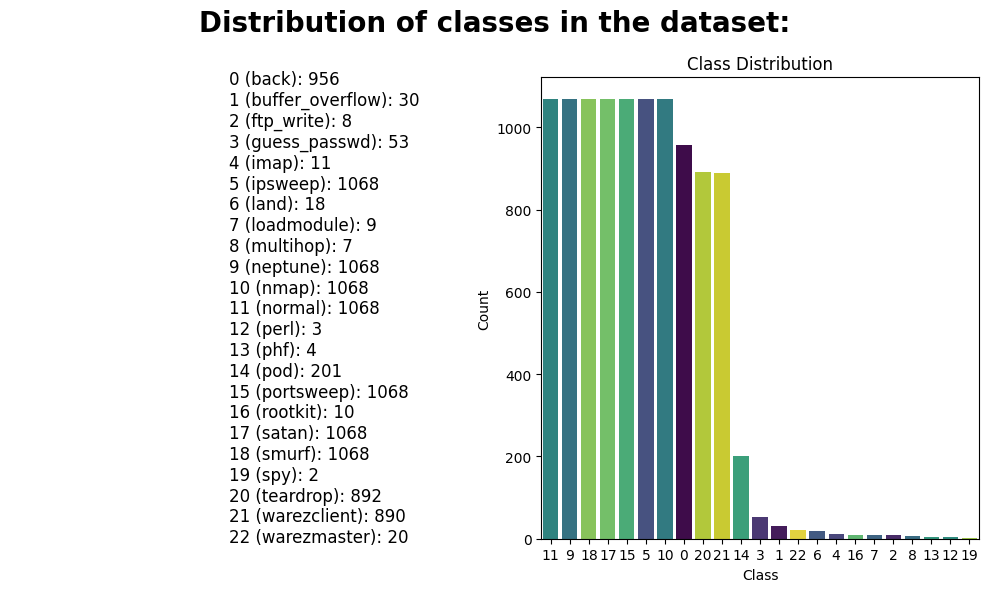

In [ ]:
class_distribution = dataset['label'].value_counts()
class_distribution = class_distribution.sort_values(ascending=False)

# Distribution bar graph
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Distribution of classes in the dataset:", fontsize=20, fontweight="bold")
ax[0].axis("off")  # Hides axes for text
text = ""+"\n".join([f"{index} ({class_label}): {class_distribution[index]}" for index, class_label in enumerate(label_encoder.classes_)])
ax[0].text(0.5, 0.5, text, fontsize=12, ha="left", va="center")
sns.barplot(x=class_distribution.index, y=class_distribution.values,
            palette="viridis", order=class_distribution.index,  # Specific order for the graph
            hue=class_distribution.index, legend=False)
ax[1].set_title("Class Distribution")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

##4. Division of the dataset

To train and evaluate machine learning models, the dataset is divided into three separate sets: Training, Validation and Testing.

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

###**Separation of features and labels**

The columns of the dataset are divided into:
* Feature (`X`): These represent the features used as input for the model.
* Labels (`y`): They correspond to the label column, which indicates whether a flow is normal or associated with a type of attack.

In [ ]:
X = dataset.drop(columns=['label'])  # Exclude the 'label' column for features
y = dataset['label']  # Labels

###**Class Balancing**

If the training set presents a significant imbalance between classes, the `SMOTE` (Synthetic Minority Oversampling Technique) is used. This technique generates synthetic samples for the least represented classes, improving the predictive capabilities of the model.

In [ ]:
balance_with_smote = False  # Change to True if you do wish to apply SMOTE
if balance_with_smote:
    print("Application of SMOTE for class balancing in the Training set...")
    smote = SMOTE(random_state=42, k_neighbors=min(5, y.value_counts().min() - 1))
    X_balanced, y_balanced = smote.fit_resample(X, y)
    print("Successfully balanced training set!")
    print("Class distribution after SMOTE:")
    for index, class_label in enumerate(label_encoder.classes_):
      if index in y_balanced.value_counts().index:  # Check if the index is present
        print(f"{index} ({class_label}): {y_balanced.value_counts()[index]}")
      else:
        print(f"{index} ({class_label}): 0") # Print 0 if not present
else:
    X_balanced, y_balanced = X, y
    print("The choice was made not to use SMOTE...")
    print("Class distribution without SMOTE:")
    for index, class_label in enumerate(label_encoder.classes_):
      if index in y_balanced.value_counts().index:  # Check if the index is present
        print(f"{index} ({class_label}): {y_balanced.value_counts()[index]}")
      else:
        print(f"{index} ({class_label}): 0") # Print 0 if not present

The choice was made not to use SMOTE...
Class distribution without SMOTE:
0 (back): 956
1 (buffer_overflow): 30
2 (ftp_write): 8
3 (guess_passwd): 53
4 (imap): 11
5 (ipsweep): 1068
6 (land): 18
7 (loadmodule): 9
8 (multihop): 7
9 (neptune): 1068
10 (nmap): 1068
11 (normal): 1068
12 (perl): 3
13 (phf): 4
14 (pod): 201
15 (portsweep): 1068
16 (rootkit): 10
17 (satan): 1068
18 (smurf): 1068
19 (spy): 2
20 (teardrop): 892
21 (warezclient): 890
22 (warezmaster): 20


It was decided not to create synthetic samples

###**Suddivisione dei dati**

The dataset is divided into three sets with the following proportions:
* **Training set** (70%): to train the model.
* **Validation set** (15%): to optimise parameters and evaluate performance during training.
* **Test set** (15%): to evaluate the final performance of the model.

Stratification (`stratify`) ensures that the distribution of classes is uniform between the different sets.

In [ ]:
# Initial division into Training+Validation and Test set (85%-15%)
X_temp, X_test, y_temp, y_test = train_test_split(X_balanced, y_balanced, test_size=0.15, random_state=42, stratify=y_balanced)

# Breakdown of Training+Validation into Training (70%) and Validation (15%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

print(f"Set sizes:")
print(f"Training set (rows, columns): {X_train.shape}\nValidation set (rows, columns): {X_val.shape}\nTest set (rows, columns): {X_test.shape}")

Set sizes:
Training set (rows, columns): (7412, 32)
Validation set (rows, columns): (1589, 32)
Test set (rows, columns): (1589, 32)


In [ ]:
print("Class distribution in sets:")
print("Training set:")
for index, class_label in enumerate(label_encoder.classes_):
  print(f"{index} ({class_label}): {y_train.value_counts()[index]}")

Class distribution in sets:
Training set:
0 (back): 669
1 (buffer_overflow): 20
2 (ftp_write): 6
3 (guess_passwd): 37
4 (imap): 7
5 (ipsweep): 748
6 (land): 12
7 (loadmodule): 6
8 (multihop): 5
9 (neptune): 748
10 (nmap): 748
11 (normal): 748
12 (perl): 2
13 (phf): 2
14 (pod): 141
15 (portsweep): 748
16 (rootkit): 7
17 (satan): 748
18 (smurf): 748
19 (spy): 2
20 (teardrop): 624
21 (warezclient): 622
22 (warezmaster): 14


In [ ]:
print("Validation set:")
for index, class_label in enumerate(label_encoder.classes_):
  if index in y_val.value_counts().index:  # Check if the index is present
    print(f"{index} ({class_label}): {y_val.value_counts()[index]}")
  else:
    print(f"{index} ({class_label}): 0") # Print 0 if not present

Validation set:
0 (back): 144
1 (buffer_overflow): 5
2 (ftp_write): 1
3 (guess_passwd): 8
4 (imap): 2
5 (ipsweep): 160
6 (land): 3
7 (loadmodule): 2
8 (multihop): 1
9 (neptune): 160
10 (nmap): 160
11 (normal): 160
12 (perl): 0
13 (phf): 1
14 (pod): 30
15 (portsweep): 160
16 (rootkit): 1
17 (satan): 160
18 (smurf): 160
19 (spy): 0
20 (teardrop): 134
21 (warezclient): 134
22 (warezmaster): 3


In [ ]:
print("Test set:")
for index, class_label in enumerate(label_encoder.classes_):
  if index in y_test.value_counts().index:  # Check if the index is present
    print(f"{index} ({class_label}): {y_test.value_counts()[index]}")
  else:
    print(f"{index} ({class_label}): 0") # Print 0 if not present

Test set:
0 (back): 143
1 (buffer_overflow): 5
2 (ftp_write): 1
3 (guess_passwd): 8
4 (imap): 2
5 (ipsweep): 160
6 (land): 3
7 (loadmodule): 1
8 (multihop): 1
9 (neptune): 160
10 (nmap): 160
11 (normal): 160
12 (perl): 1
13 (phf): 1
14 (pod): 30
15 (portsweep): 160
16 (rootkit): 2
17 (satan): 160
18 (smurf): 160
19 (spy): 0
20 (teardrop): 134
21 (warezclient): 134
22 (warezmaster): 3


#Model development and selection

##1. Selection of algorithms

We are going to train and evaluate two machine learning models for multiclass classification of the `NSL-KDD` dataset. The performance of a traditional model and a neural network will be compared.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

###**Random Forest**

This model is known for its ability to handle noisy data and identify the most important features.

In [ ]:
print("Random Forest model training...")
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

Random Forest model training...


RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Predictions on Validation Set
rf_predictions = rf_model.predict(X_val)

####**Evaluation**

Performance is measured using a classification report (Precision, Recall, F1-score for each class) and the overall accuracy on the validation set.

In [ ]:
print("Evaluation of the Random Forest model:")

# Generates the classification report as a dictionary
report_dict = classification_report(y_val, rf_predictions, zero_division=1, output_dict=True)

# Converts the report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Add a numeric index for classes (optional)
if 'label_encoder' in locals():  # Check whether label_encoder exists
    report_df.index = [f"{index} ({label_encoder.classes_[int(index)]})"
    if index.isdigit() else index
                       for index in report_df.index]
empty_row = pd.DataFrame([['', '', '', '']], columns=report_df.columns, index=[" "])
report_df = pd.concat([report_df.iloc[:-3], empty_row, report_df.iloc[-3:]])

# Print the DataFrame in table format
print(report_df)

# Displays the DataFrame in a readable manner
report_df.style.set_caption("Classification Report").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'),
     ('text-align', 'center')]}]
)


print(f"\nAccuracy: {accuracy_score(y_val, rf_predictions):.2f}")
print("\nCalculate metrics for each label, and find their unweighted mean.")
print(f"F1_macro: {f1_score(y_val, rf_predictions, average='macro'):.2f}")
print("\nCalculate metrics globally")
print(f"F1_micro: {f1_score(y_val, rf_predictions, average='micro'):.2f}")
print("\nCalculate metrics for each label, and find their average weighted.")
print(f"F1_weighted: {f1_score(y_val, rf_predictions, average='weighted'):.2f}")

Evaluation of the Random Forest model:
                    precision    recall  f1-score   support
0 (back)                  1.0       1.0       1.0     144.0
1 (buffer_overflow)  0.833333       1.0  0.909091       5.0
2 (ftp_write)             1.0       1.0       1.0       1.0
3 (guess_passwd)          1.0       1.0       1.0       8.0
4 (imap)                  1.0       0.5  0.666667       2.0
5 (ipsweep)               1.0   0.99375  0.996865     160.0
6 (land)                  1.0       1.0       1.0       3.0
7 (loadmodule)            0.5       0.5       0.5       2.0
8 (multihop)              1.0       0.0       0.0       1.0
9 (neptune)               1.0       1.0       1.0     160.0
10 (nmap)                 1.0   0.99375  0.996865     160.0
11 (normal)          0.969697       1.0  0.984615     160.0
13 (phf)                  1.0       1.0       1.0       1.0
14 (pod)                  1.0       1.0       1.0      30.0
15 (portsweep)       0.993789       1.0  0.996885     160.0
1

###**Rete Neurale Multilayer Perceptron (MLP)**

A fully connected neural network designed to capture complex patterns in data.

In [ ]:
print("Preparation of data for the MLP model...")
# Conversion of labels into categorical format for the neural network
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
input_dim = X_train.shape[1]  # Number of input features
num_classes = y_train_cat.shape[1]  # Number of classes

Preparation of data for the MLP model...


An input layer with **128 neurons** and `ReLU` activation.
A `Dropout` layer to prevent overfitting.
A second hidden layer with **64 neurons** and `ReLU` activation.
An output layer with `Softmax` activation for multiclass classification.

In [ ]:
print("Creation of the MLP model...")
input_shape = (X_train.shape[1],)
mlp_model = Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Softmax for multiclass output
])
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['f1_score'])

Creation of the MLP model...


####**Training**

Use `categorical_crossentropy` loss function. Trained for **20 epochs** with a **batch size of 32**.

In [ ]:
print("Training the MLP model...")
mlp_model.fit(X_train, y_train_cat, epochs=20, batch_size=32,
              validation_data=(X_val, y_val_cat), verbose=1)

Training the MLP model...
Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.1180 - loss: 3.0001 - val_f1_score: 0.4398 - val_loss: 0.7796
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.3588 - loss: 0.9670 - val_f1_score: 0.5274 - val_loss: 0.3963
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.4688 - loss: 0.5800 - val_f1_score: 0.5811 - val_loss: 0.2507
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.5174 - loss: 0.4225 - val_f1_score: 0.5824 - val_loss: 0.1940
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.5226 - loss: 0.3401 - val_f1_score: 0.5855 - val_loss: 0.1532
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.5698 - loss: 0.2985 - val_f1_score: 0.6669 - val_loss: 0.1310
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.5503 - loss: 0.2565 - val_f1_score: 0.6683 - val_loss: 0.1083
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.5951 - loss:

In [ ]:
# Predictions on Validation Set
mlp_predictions = mlp_model.predict(X_val)
# Convert probabilities to classes
mlp_predictions_classes = mlp_predictions.argmax(axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


####**Evaluation**

Performance is measured using the classification report and `F1_score` on the validation set.
The model is more flexible than Random Forest, but requires more computing power and attention to adjusting the hyper-parameters.

In [ ]:
print("Evaluation of the MLP model:")

# Generates the classification report as a dictionary
report_dict = classification_report(y_val, mlp_predictions_classes,
                                    zero_division=1, output_dict=True)

# Converts the report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Add a numeric index for classes (optional)
if 'label_encoder' in locals():  # Check whether label_encoder exists
    report_df.index = [f"{index} ({label_encoder.classes_[int(index)]})"
    if index.isdigit() else index
                       for index in report_df.index]
empty_row = pd.DataFrame([['', '', '', '']], columns=report_df.columns, index=[" "])
report_df = pd.concat([report_df.iloc[:-3], empty_row, report_df.iloc[-3:]])

# Print the DataFrame in table format
print(report_df)

# Displays the DataFrame in a readable manner
report_df.style.set_caption("Classification Report").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'),
     ('text-align', 'center')]}]
)


print(f"\nAccuracy: {accuracy_score(y_val, mlp_predictions_classes):.2f}")
print("\nCalculate metrics for each label, and find their unweighted mean.")
print(f"F1_macro: {f1_score(y_val, mlp_predictions_classes, average='macro'):.2f}")
print("\nCalculate metrics globally")
print(f"F1_micro: {f1_score(y_val, mlp_predictions_classes, average='micro'):.2f}")
print("\nCalculate metrics for each label, and find their average weighted.")
print(f"F1_weighted: {f1_score(y_val, mlp_predictions_classes, average='weighted'):.2f}")

Evaluation of the MLP model:
                    precision    recall  f1-score   support
0 (back)             0.993007  0.986111  0.989547     144.0
1 (buffer_overflow)  0.833333       1.0  0.909091       5.0
2 (ftp_write)             1.0       1.0       1.0       1.0
3 (guess_passwd)          1.0       1.0       1.0       8.0
4 (imap)                  1.0       0.5  0.666667       2.0
5 (ipsweep)          0.993789       1.0  0.996885     160.0
6 (land)                  1.0       1.0       1.0       3.0
7 (loadmodule)            0.0       0.0       0.0       2.0
8 (multihop)              1.0       0.0       0.0       1.0
9 (neptune)          0.987654       1.0  0.993789     160.0
10 (nmap)                 1.0   0.99375  0.996865     160.0
11 (normal)          0.974843   0.96875  0.971787     160.0
13 (phf)                  1.0       1.0       1.0       1.0
14 (pod)                  1.0       1.0       1.0      30.0
15 (portsweep)            1.0    0.9875  0.993711     160.0
16 (rootkit

##2. Optimisation of hyperparameters

We are going to use two search techniques to find the optimal hyper-parameters of a Random Forest model and a neural network (MLP).

In [ ]:
from sklearn.model_selection import GridSearchCV

###Grid Search for Random Forests

Grid Search systematically explores a predefined grid of hyper-parameters and evaluates the performance of each combination using `cross-validation`.

* `n_estimators`: Number of trees in the forest
* `max_depth`: Maximum tree depth
* `min_samples_split`: Minimum number of samples required to subdivide a node
* `min_samples_leaf`: Minimum number of samples in a leaf

In [ ]:
param_grid_rf = {
    'n_estimators': [110, 120, 130],
    'max_depth': [None, 10, 20],
    'min_samples_split': list(range(2, 10 + 1)),
    'min_samples_leaf': list(range(1, 4 + 1))
}

The performance of each model is measured by the average `f1_score` calculated by cross-validation (2-fold).

In [ ]:
print("Execution of Grid Search for Random Forest...")
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                              cv=2, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

Execution of Grid Search for Random Forest...
Fitting 2 folds for each of 324 candidates, totalling 648 fits


GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [110, 120, 130]},
             scoring='f1_macro', verbose=1)

In [ ]:
print("Best parameters found for Random Forest:")
print(grid_search_rf.best_params_)
print(f"Best F1 (Validation Set): {grid_search_rf.best_score_:.2f}")
best_rf_model = grid_search_rf.best_estimator_

Best parameters found for Random Forest:
{'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 120}
Best F1 (Validation Set): 0.80


###Random Search per Rete Neurale (MLP)

Random Search randomly selects parameter combinations from a defined search space, being more efficient for complex models with many hyper-parameters.

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
# Define the function to build the MLP model (identical to your existing build_mlp_model)
def build_mlp_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))

    # Tune the number of units in the first Dense layer
    hp_units1 = hp.Int('units1', min_value=64, max_value=256, step=64)
    model.add(keras.layers.Dense(units=hp_units1, activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout1', min_value=0.2, max_value=0.4, step=0.1)))

    # Tune the number of units in the second Dense layer
    hp_units2 = hp.Int('units2', min_value=32, max_value=128, step=32)
    model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout2', min_value=0.2, max_value=0.4, step=0.1)))

    model.add(keras.layers.Dense(len(y_train.unique()), activation='softmax'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.F1Score(average='macro')])
    return model

# Create a Keras Tuner
tuner = kt.RandomSearch(
    build_mlp_model,
    objective=kt.Objective('val_f1_score', direction='max'),
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=3,  # Number of models to train per combination
    directory='my_dir',
    project_name='intro_to_kt'
)

Each configuration is cross-validated (3-fold) using `f1_score` as the main metric.

In [ ]:
print("Performing Random Search for Neural Network...")
tuner.search(X_train, to_categorical(y_train), epochs=20,
             validation_data=(X_val, to_categorical(y_val)))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 00m 46s]
val_f1_score: 0.5504702925682068

Best val_f1_score So Far: 0.6616191069285074
Total elapsed time: 00h 07m 44s


In [ ]:
print("Better parameters for the neural network (MLP):")
print(best_hps.values)
print(f"Best F1 (Validation Set): {tuner.oracle.get_best_trials(num_trials=1)[0].score:.2f}")
best_mlp_model = tuner.hypermodel.build(best_hps)

Better parameters for the neural network (MLP):
{'units1': 192, 'dropout1': 0.30000000000000004, 'units2': 128, 'dropout2': 0.2, 'learning_rate': 0.01}
Best F1 (Validation Set): 0.66


#Training and validation

##Training

In this section, we train the optimised Random Forest and MLP models using preprocessed data. Furthermore, we evaluate their performance both via cross-validation and on the validation set.

In [ ]:
!pip install scikit-learn --upgrade
!pip install scikeras --upgrade
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold

###1. Random Forest

The optimised Random Forest model is trained on the balanced training data.

In [ ]:
print("Random Forest model training optimised...")
best_rf_model.fit(X_train, y_train)

Random Forest model training optimised...


RandomForestClassifier(class_weight='balanced', min_samples_leaf=3,
                       min_samples_split=8, n_estimators=120, random_state=42)

To estimate the robustness of the model, we use 2-fold cross-validation. The `F1_score` and `standard deviation` are calculated to analyse the variability of performance between the different folds.

In [ ]:
print("Performing Cross-Validation (2-fold) for Random Forest...")
cv_scores_rf = cross_val_score(best_rf_model, X_train, y_train, cv=2, scoring='f1_macro')
print(f"Average f1_macro from Cross-Validation (Random Forest): {cv_scores_rf.mean():.2f} ± {cv_scores_rf.std():.2f}")

Performing Cross-Validation (2-fold) for Random Forest...
Average f1_macro from Cross-Validation (Random Forest): 0.80 ± 0.02


We measure the `f1_score` of the model on the validation set. We generate a classification report highlighting precision, recall and F1-score for each class.

In [ ]:
print("Evaluation on the Validation Set (MLP)...")
# Generates the classification report as a dictionary
report_dict = classification_report(y_val, mlp_predictions_classes,
                                    zero_division=1, output_dict=True)

# Converts the report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Add a numeric index for classes (optional)
if 'label_encoder' in locals():  # Check whether label_encoder exists
    report_df.index = [f"{index} ({label_encoder.classes_[int(index)]})"
    if index.isdigit() else index
                       for index in report_df.index]
empty_row = pd.DataFrame([['', '', '', '']], columns=report_df.columns, index=[" "])
report_df = pd.concat([report_df.iloc[:-3], empty_row, report_df.iloc[-3:]])

# Print the DataFrame in table format
print(report_df)

# Displays the DataFrame in a readable manner
report_df.style.set_caption("Classification Report").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'),
     ('text-align', 'center')]}]
)


print(f"\nAccuracy: {accuracy_score(y_val, mlp_predictions_classes):.2f}")
print("\nCalculate metrics for each label, and find their unweighted mean.")
print(f"F1_macro: {f1_score(y_val, mlp_predictions_classes, average='macro'):.2f}")
print("\nCalculate metrics globally")
print(f"F1_micro: {f1_score(y_val, mlp_predictions_classes, average='micro'):.2f}")
print("\nCalculate metrics for each label, and find their average weighted.")
print(f"F1_weighted: {f1_score(y_val, mlp_predictions_classes, average='weighted'):.2f}")

Evaluation on the Validation Set (MLP)...
                    precision    recall  f1-score   support
0 (back)             0.993007  0.986111  0.989547     144.0
1 (buffer_overflow)  0.833333       1.0  0.909091       5.0
2 (ftp_write)             1.0       1.0       1.0       1.0
3 (guess_passwd)          1.0       1.0       1.0       8.0
4 (imap)                  1.0       0.5  0.666667       2.0
5 (ipsweep)          0.993789       1.0  0.996885     160.0
6 (land)                  1.0       1.0       1.0       3.0
7 (loadmodule)            0.0       0.0       0.0       2.0
8 (multihop)              1.0       0.0       0.0       1.0
9 (neptune)          0.987654       1.0  0.993789     160.0
10 (nmap)                 1.0   0.99375  0.996865     160.0
11 (normal)          0.974843   0.96875  0.971787     160.0
13 (phf)                  1.0       1.0       1.0       1.0
14 (pod)                  1.0       1.0       1.0      30.0
15 (portsweep)            1.0    0.9875  0.993711     160.

###2. Multilayer Perceptron Neural Network (MLP)

The optimised MLP model is trained using pre-processed data and labels in categorical format.

In [ ]:
print("Training of the optimised MLP model...")
best_mlp_model = build_mlp_model(best_hps)
best_mlp_model.fit(X_train, to_categorical(y_train))

Training of the optimised MLP model...
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.3527 - loss: 1.2980


We perform a 2-fold cross-validation for the MLP model, calculating the mean accuracy and standard deviation.

In [ ]:
print("Performing Cross-Validation (2-fold) for MLP...")
# Initialise layering
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv_scores_mlp = []

# Manual loop for cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    # Use .iloc to access rows by index
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Create the template
    best_mlp_model = build_mlp_model(best_hps)

    # Train the model
    best_mlp_model.fit(X_train_fold, to_categorical(y_train_fold),
                       epochs=20, batch_size=32, verbose=0)

    # Predictions
    y_pred = best_mlp_model.predict(X_val_fold).argmax(axis=1)

    # Calculate F1-score
    f1 = f1_score(y_val_fold, y_pred, average='macro')
    cv_scores_mlp.append(f1)

# Mean and standard deviation
print(f"Average f1 from Cross-Validation (MLP): {np.mean(cv_scores_mlp):.2f} ± {np.std(cv_scores_mlp):.2f}")

Performing Cross-Validation (2-fold) for MLP...
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Average f1 from Cross-Validation (MLP): 0.60 ± 0.03


The model predictions on the validation set are compared with the actual labels. We generate a classification report and measure the overall accuracy.

In [ ]:
print("Evaluation on the Validation Set (MLP)...")
mlp_predictions = best_mlp_model.predict(X_val)
mlp_predictions_classes = mlp_predictions.argmax(axis=1)
# Generates the classification report as a dictionary
report_dict = classification_report(y_val, mlp_predictions_classes,
                                    zero_division=1, output_dict=True)

# Converts the report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Add a numeric index for classes (optional)
if 'label_encoder' in locals():  # Check whether label_encoder exists
    report_df.index = [f"{index} ({label_encoder.classes_[int(index)]})"
    if index.isdigit() else index
                       for index in report_df.index]
empty_row = pd.DataFrame([['', '', '', '']], columns=report_df.columns, index=[" "])
report_df = pd.concat([report_df.iloc[:-3], empty_row, report_df.iloc[-3:]])

# Print the DataFrame in table format
print(report_df)

# Displays the DataFrame in a readable manner
report_df.style.set_caption("Classification Report").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'),
     ('text-align', 'center')]}]
)


print(f"\nAccuracy: {accuracy_score(y_val, mlp_predictions_classes):.2f}")
print("\nCalculate metrics for each label, and find their unweighted mean.")
print(f"F1_macro: {f1_score(y_val, mlp_predictions_classes, average='macro'):.2f}")
print("\nCalculate metrics globally")
print(f"F1_micro: {f1_score(y_val, mlp_predictions_classes, average='micro'):.2f}")
print("\nCalculate metrics for each label, and find their average weighted.")
print(f"F1_weighted: {f1_score(y_val, mlp_predictions_classes, average='weighted'):.2f}")

Evaluation on the Validation Set (MLP)...
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
                    precision    recall  f1-score   support
0 (back)                  1.0  0.986111  0.993007     144.0
1 (buffer_overflow)  0.714286       1.0  0.833333       5.0
2 (ftp_write)             1.0       0.0       0.0       1.0
3 (guess_passwd)          1.0       1.0       1.0       8.0
4 (imap)                  1.0       0.0       0.0       2.0
5 (ipsweep)          0.981595       1.0  0.990712     160.0
6 (land)                 0.75       1.0  0.857143       3.0
7 (loadmodule)            1.0       0.0       0.0       2.0
8 (multihop)              1.0       0.0       0.0       1.0
9 (neptune)          0.969512   0.99375  0.981481     160.0
10 (nmap)            0.952096   0.99375  0.972477     160.0
11 (normal)           0.96732     0.925  0.945687     160.0
13 (phf)                  1.0       0.0       0.0       1.0
14 (pod)                  1.0       1.0       1.0      30.0
15 (portsweep)   

##Evaluation Metrics

We evaluate the performance of the **Random Forest** and **MLP** models on the validation set using the following metrics:

In [ ]:
from sklearn.metrics import confusion_matrix

###**1. Classification Ratio**

- **Precision**: The percentage of correct predictions compared to all predictions made for a class.
- **Recall**: The percentage of correctly identified examples compared to all actual examples for a class.
- **F1-Score**: A harmonic average between accuracy and recall.
- **Accuracy**: The percentage of correct predictions out of the total.

In [ ]:
# Valutazione del modello Random Forest
print("Evaluation of the Random Forest model on the Validation Set:")
print(f"Evaluation metrics for the model Random Forest:\n")
print(classification_report(y_val, rf_predictions, digits=4, zero_division=1)) # Add zero_division=1 here
print(f"F1_score macro: {f1_score(y_val, rf_predictions, average='macro', zero_division=1):.4f}") # Add zero_division=1 here

Evaluation of the Random Forest model on the Validation Set:
Evaluation metrics for the model Random Forest:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       144
           1     0.8333    1.0000    0.9091         5
           2     1.0000    1.0000    1.0000         1
           3     1.0000    1.0000    1.0000         8
           4     1.0000    0.5000    0.6667         2
           5     1.0000    0.9938    0.9969       160
           6     1.0000    1.0000    1.0000         3
           7     0.5000    0.5000    0.5000         2
           8     1.0000    0.0000    0.0000         1
           9     1.0000    1.0000    1.0000       160
          10     1.0000    0.9938    0.9969       160
          11     0.9697    1.0000    0.9846       160
          13     1.0000    1.0000    1.0000         1
          14     1.0000    1.0000    1.0000        30
          15     0.9938    1.0000    0.9969       160
          16     1.0000  

In [ ]:
# Valutazione del modello MLP
print("Evaluation of the MLP model on the Validation Set:")
print(f"Evaluation metrics for the model MLP:\n")
print(classification_report(y_val, mlp_predictions_classes, digits=4, zero_division=1)) # Add zero_division=1 here
print(f"F1_score macro: {f1_score(y_val, mlp_predictions_classes, average='macro', zero_division=1):.4f}") # Add zero_division=1 here

Evaluation of the MLP model on the Validation Set:
Evaluation metrics for the model MLP:

              precision    recall  f1-score   support

           0     1.0000    0.9861    0.9930       144
           1     0.7143    1.0000    0.8333         5
           2     1.0000    0.0000    0.0000         1
           3     1.0000    1.0000    1.0000         8
           4     1.0000    0.0000    0.0000         2
           5     0.9816    1.0000    0.9907       160
           6     0.7500    1.0000    0.8571         3
           7     1.0000    0.0000    0.0000         2
           8     1.0000    0.0000    0.0000         1
           9     0.9695    0.9938    0.9815       160
          10     0.9521    0.9938    0.9725       160
          11     0.9673    0.9250    0.9457       160
          13     1.0000    0.0000    0.0000         1
          14     1.0000    1.0000    1.0000        30
          15     0.9936    0.9750    0.9842       160
          16     1.0000    0.0000    0.0000  

###**2. Confusion Matrix**.

Provides a visual representation of classification errors for each class. Shows true positives, false positives, true negatives and false negatives, helping to identify possible confusions between classes.

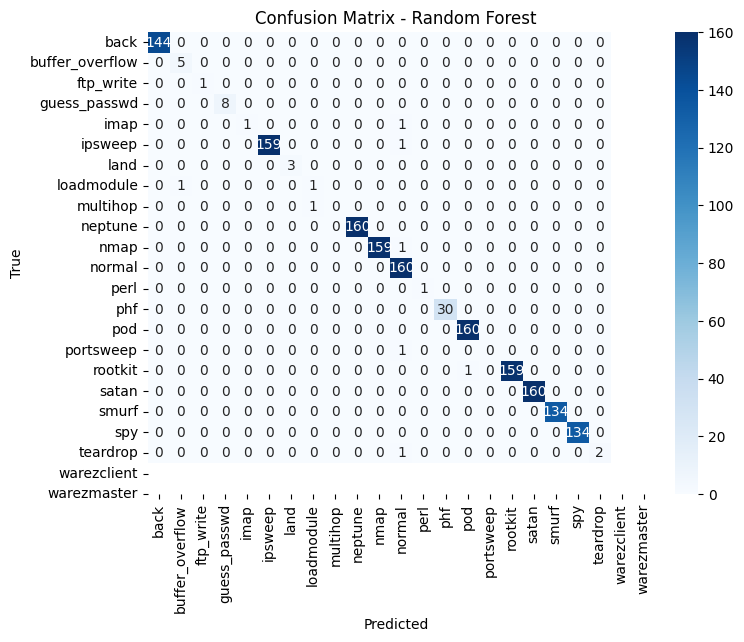

In [ ]:
cm = confusion_matrix(y_val, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f"Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

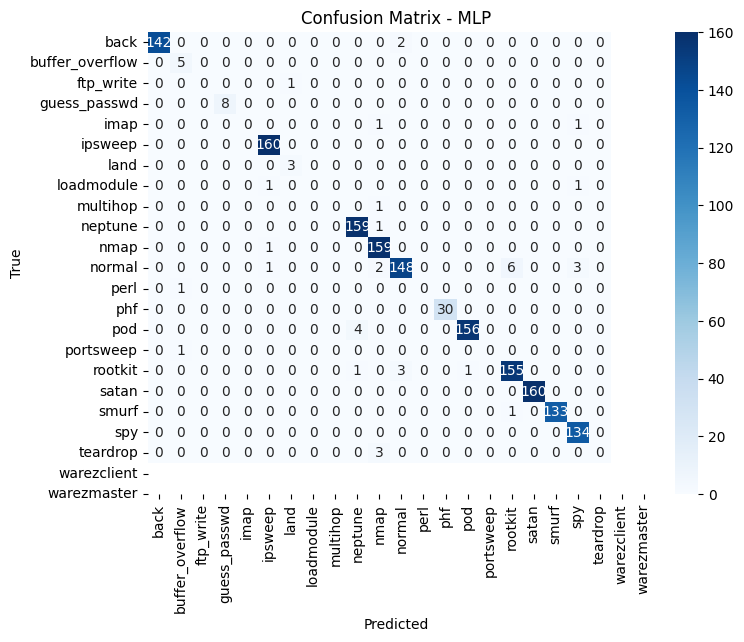

In [ ]:
cm = confusion_matrix(y_val, mlp_predictions_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f"Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#Performance testing and analysis

##Evaluation on the test set

In this section, we perform the final evaluation of the Random Forest and MLP models on the test set to measure their overall performance. We also record the inference time to compare the computational cost of each model.

In [ ]:
import time

###Evaluation on Test Set

For each model, we calculate:
- **Classification Report**: Includes detailed metrics such as precision, recall and F1-score for each class.
- **F1-Score**: A harmonic average between accuracy and recall.
- **Inference Time**: Total duration required for the model to process and classify the test set.

In [ ]:
# Function for recording inference time and evaluating metrics
def evaluate_on_test_set(model, X_test, y_test, model_name):
    """
    It evaluates the model on the test set and records performance metrics and inference time.
    """
    print(f"Model evaluation {model_name} on the test set...")
    start_time = time.time()
    predictions = model.predict(X_test)
    inference_time = time.time() - start_time

    # Conversione predizioni per MLP
    if model_name == "MLP":
        predictions = predictions.argmax(axis=1)  # Per Softmax

    # Metriche di performance
    print(classification_report(y_test, predictions, digits=4, zero_division=1))
    f1 = f1_score(y_test, predictions, average='macro')
    print(f"F1 on the test set: {f1:.4f}")
    print(f"Inference time on Test Set: {inference_time:.4f} seconds")

    return f1, inference_time

###Models evaluated

####**Random Forest**:

In [ ]:
rf_f1, rf_time = evaluate_on_test_set(best_rf_model, X_test, y_test, "Random Forest")

Model evaluation Random Forest on the test set...
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       143
           1     1.0000    1.0000    1.0000         5
           2     0.5000    1.0000    0.6667         1
           3     1.0000    1.0000    1.0000         8
           4     1.0000    1.0000    1.0000         2
           5     0.9573    0.9812    0.9691       160
           6     1.0000    1.0000    1.0000         3
           7     1.0000    1.0000    1.0000         1
           8     0.5000    1.0000    0.6667         1
           9     1.0000    1.0000    1.0000       160
          10     0.9809    0.9625    0.9716       160
          11     0.9684    0.9563    0.9623       160
          12     0.5000    1.0000    0.6667         1
          13     1.0000    1.0000    1.0000         1
          14     1.0000    0.9667    0.9831        30
          15     0.9938    0.9938    0.9938       160
          16     1.0000    0.00

####**MLP (Neural Network)**:

In [ ]:
mlp_f1, mlp_time = evaluate_on_test_set(best_mlp_model, X_test, y_test, "MLP")

Model evaluation MLP on the test set...
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0     0.9792    0.9860    0.9826       143
           1     0.7143    1.0000    0.8333         5
           2     1.0000    0.0000    0.0000         1
           3     1.0000    1.0000    1.0000         8
           4     1.0000    0.0000    0.0000         2
           5     0.9509    0.9688    0.9598       160
           6     1.0000    1.0000    1.0000         3
           7     1.0000    0.0000    0.0000         1
           8     1.0000    0.0000    0.0000         1
           9     0.9937    0.9875    0.9906       160
          10     0.8807    0.9688    0.9226       160
          11     0.9161    0.8875    0.9016       160
          12     1.0000    0.0000    0.0000         1
          13     1.0000    0.0000    0.0000         1
          14     1.0000    0.9333    0.9655        30
          15     0.9812    0.9812    0.9812       160
  

###Performance Comparison

- **F1-Score**: A harmonic average between accuracy and recall.
- **Computational Cost**: We analyse the inference time to determine the efficiency of each model.

In [ ]:
print("Model comparison:")
print(f"Random Forest - F1: {rf_f1:.4f}, Inference Time: {rf_time:.4f} seconds")
print(f"MLP           - F1: {mlp_f1:.4f}, Inference Time: {mlp_time:.4f} seconds")

Model comparison:
Random Forest - F1: 0.9025, Inference Time: 0.0863 seconds
MLP           - F1: 0.6111, Inference Time: 0.4616 seconds


##Feature importance

Analysing the importance of features is an essential step in understanding which variables have the greatest impact on model decision-making. In this section, we use the Random Forest model to identify the most relevant features for multiclass classification.

###1. Calculation of Feature Importance

The Random Forest model provides an attribute called `feature_importances_`, which assigns each feature an importance score based on its ability to reduce impurity during decision tree splits. These scores represent the percentage contribution of each feature to the model's prediction.

In [ ]:
print("Calculation of feature importance (Random Forest)...")
feature_importances = best_rf_model.feature_importances_

Calculation of feature importance (Random Forest)...


In [ ]:
# Creating a DataFrame to organise data
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

###2. Sorting the Features

Features are sorted according to importance in descending order.

In [ ]:
importance_df = importance_df.sort_values(by='Importance', ascending=False)

We show the 10 most significant features, both in tabular and visual format.

In [ ]:
print("Top 10 most important features:")
print(importance_df.head(10))

Top 10 most important features:
                        Feature  Importance
4                     src_bytes    0.105592
2                       service    0.078049
5                     dst_bytes    0.077518
28           dst_host_srv_count    0.056014
27               dst_host_count    0.051136
7                wrong_fragment    0.049178
20                        count    0.045806
29       dst_host_diff_srv_rate    0.042440
31  dst_host_srv_diff_host_rate    0.041690
30  dst_host_same_src_port_rate    0.041650


###3. Display

We create a bar graph showing the relative importance of the top 10 features. The graph helps to visually identify the key variables that the model considers most influential.

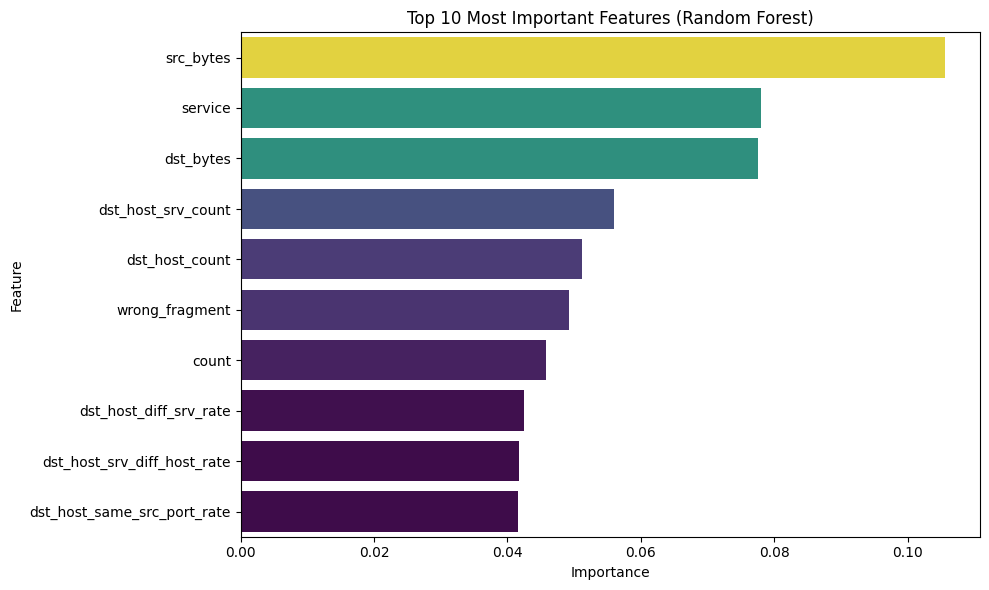

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), hue='Importance', palette='viridis', legend=False)
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()